# Part D: Planning for your SDL (MacOS version)

In this notebook, you will learn more about the third step of an SDL: Planning.

Go to [sdl4kids.com](http://sdl4kids.com) for the Windows version.

If you have any questions, check out the [FAQ](https://sites.google.com/matterhorn.studio/sdl4kids/faq)!

## Introduction

We will look at different ways to plan your experiment, i.e. selecting which color to try next:

1. Random
2. Grid
3. Bayesian Optimisation

## (1) Strategy: Random

**Goal**: You will learn how to use a random search to find the best RGB combination.

Random here means the same as throwing a die with 6 sides: Each side, 1 to 6, has an equal probability (1/6 = 16.6%) of occurence. 

With RGB colors, we essentially have three dice — one for each R, G and B — with each die having 256 sides, representing the numbers 0 to 255. Each side has equal probability.

We will throw these three die to select the next RGB experiment. If we do that 100 times, many RGB colors will be far off our target color, but with a certain probability, some will get close.

In [106]:
import random
import numpy as np
import cv2

# Function to generate random color
def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return blue, green, red  # OpenCV uses BGR color format

# Function to calculate the error between two colors
def calculate_error(color1, color2):
    return np.sqrt((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2)


In [107]:

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (0, 0, 255)  # Red color (BGR format)

# Create an empty list to store the error values
error_values = []

# Main loop
max_iterations = 50  # Set the desired number of iterations

candidate_color = (0,0,0) # Initial candidate

for iteration in range(max_iterations):
    

    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = candidate_color
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    #rgb_measurement = characterise()  
    #rgb_measurement = tuple(reversed(rgb_measurement))
    
    # Measure the color by just pretending candidate_color being the measurement 
    rgb_measurement = candidate_color
    
    # STEP 3: Planning
    
    # Calculate the error between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)

    # Add the loss value to the list
    error_values.append(error)    

    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // 50
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)

    # Add text for the loss
    error_text = f"Loss: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(50)  # Adjust the wait time (in milliseconds) as needed
    
    # Generate a new candidate color, for now we will pick one randomly
    candidate_color = generate_random_color()
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

We can now plot the error for each random RGB combination, and also a line for the best random color we have found so far.

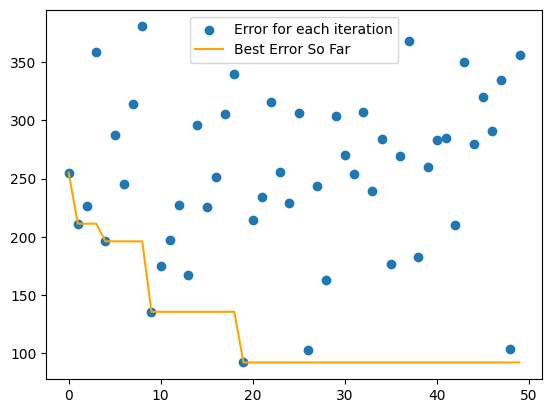

In [108]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

## (2) Strategy: Grid

We will generate a 'grid' of RGB combinations, which we then measure and pick the best point.

Image you want to cook the best pizza, but you don't know what the best time in the oven at 200 Celsius. It is most likely somehwere between 10 and 15 minutes. If we have 6 pizzas, we can just put in a pizza for each 10, 11, 12, 13, 14 and 15 minutes and then test the taste. That's a grid: We have a lower and upper bound and a limited number of experiments we can run in between, evenly spaced.

For our SDL4Kids, we have 3 variables R, G and B instead of 'minutes in the oven'. For example, we can create a grid with 5 steps for each variable. That would be 5 * 5 * 5 = 125 experiments to run. The following code generates such a grid:

In [109]:
grid_steps = 4
red = np.linspace(0, 255, grid_steps)
green = np.linspace(0, 255, grid_steps)
blue = np.linspace(0, 255, grid_steps)

grid_combinations = []
for r in red:
    for g in green:
        for b in blue:
            combination = (r,g,b)
            grid_combinations.append(combination)
grid_combinations

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 85.0),
 (0.0, 0.0, 170.0),
 (0.0, 0.0, 255.0),
 (0.0, 85.0, 0.0),
 (0.0, 85.0, 85.0),
 (0.0, 85.0, 170.0),
 (0.0, 85.0, 255.0),
 (0.0, 170.0, 0.0),
 (0.0, 170.0, 85.0),
 (0.0, 170.0, 170.0),
 (0.0, 170.0, 255.0),
 (0.0, 255.0, 0.0),
 (0.0, 255.0, 85.0),
 (0.0, 255.0, 170.0),
 (0.0, 255.0, 255.0),
 (85.0, 0.0, 0.0),
 (85.0, 0.0, 85.0),
 (85.0, 0.0, 170.0),
 (85.0, 0.0, 255.0),
 (85.0, 85.0, 0.0),
 (85.0, 85.0, 85.0),
 (85.0, 85.0, 170.0),
 (85.0, 85.0, 255.0),
 (85.0, 170.0, 0.0),
 (85.0, 170.0, 85.0),
 (85.0, 170.0, 170.0),
 (85.0, 170.0, 255.0),
 (85.0, 255.0, 0.0),
 (85.0, 255.0, 85.0),
 (85.0, 255.0, 170.0),
 (85.0, 255.0, 255.0),
 (170.0, 0.0, 0.0),
 (170.0, 0.0, 85.0),
 (170.0, 0.0, 170.0),
 (170.0, 0.0, 255.0),
 (170.0, 85.0, 0.0),
 (170.0, 85.0, 85.0),
 (170.0, 85.0, 170.0),
 (170.0, 85.0, 255.0),
 (170.0, 170.0, 0.0),
 (170.0, 170.0, 85.0),
 (170.0, 170.0, 170.0),
 (170.0, 170.0, 255.0),
 (170.0, 255.0, 0.0),
 (170.0, 255.0, 85.0),
 (170.0, 255.0, 

In [110]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (0, 0, 255)  # Red color (BGR format)

# Create an empty list to store the loss values
error_values = []

# Main loop
max_iterations = len(grid_combinations)  # Set the desired number of iterations

candidate_color = grid_combinations[0]

for iteration, grid_combination in enumerate(grid_combinations):
    

    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = candidate_color
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    #rgb_measurement = characterise()  
    #rgb_measurement = tuple(reversed(rgb_measurement))
    
    # Measure the color by just pretending candidate_color being the measurement 
    rgb_measurement = candidate_color
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)

    # Add the loss value to the list
    error_values.append(error)    

    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // (max_iterations + 1)
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)

    # Add text for the error
    error_text = f"Loss: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(50)  # Adjust the wait time (in milliseconds) as needed
    
    # Generate a new candidate color, for now we will pick one randomly
    candidate_color = grid_combination
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

Let's plot the error values for each grid combination. Notice the pattern a grid creates.

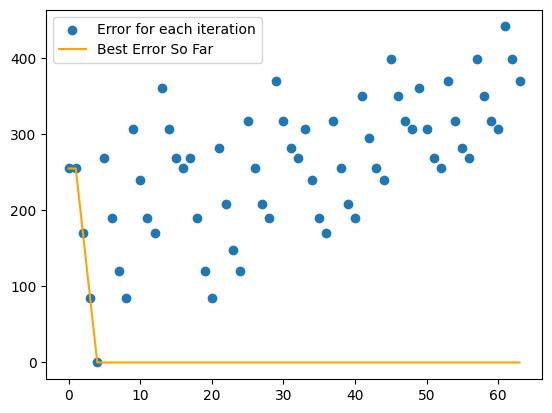

In [111]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

**Question**: Which RGB combination was closest to our goal color?

*Solution*: Check the loss graph for the combination with the smallest loss, i.e. it is closest to our goal color.

In [112]:
iteration_with_smallest_error = error_values.index(min(error_values))-1 # Index of the iteration with the smallest loss
grid_combinations[iteration_with_smallest_error]

(0.0, 0.0, 255.0)

## (3) Strategy: Bayesian Optimisation 

The *random* strategy is a good baseline we want to beat. If our search is not better than *random* then, we should just randomly experiment. With a *grid* search, we are more structured in our search, but the best experiment can still easily sleep in between the grid points.

With **Bayesian Optimisation**, we build a statistical model for decision making, i.e. steering our search. This model will represent the behaviour of our RGB color. In Material Science, it can for example represent the relationships between water content and concrete strength.

We can ask this model for the next *most informative* combination to test, collect the data, update the model and repeat.

In [113]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (255, 0, 255)  # Red color

# Create an empty list to store the loss values
error_values = []

# Main loop
max_iterations = 25  # Set the desired number of iterations


# Bayesian Optimisation
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def objective_function(R, G, B):
    # Simulate the outcome based on the RGB values
    outcome = calculate_error(goal_color, {'R': R, 'G': G, 'B': B})
    return outcome

# Define the utility function (Expected Improvement)
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

# Define the search space bounds
rgb_bounds = {'R': (0, 255), 'G': (0, 255), 'B': (0, 255)}

# Define the Bayesian optimization function
optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=rgb_bounds,
        random_state=1,
        verbose=2, 
        allow_duplicate_points=True
)

candidate_color = (0,0,0) # Initial color
for iteration in range(max_iterations):

    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    #rgb_measurement = characterise()  
    #rgb_measurement = tuple(reversed(rgb_measurement))
    
    # Measure the color by just pretending candidate_color being the measurement 
    rgb_measurement = candidate_color
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)

    # Add the loss value to the list
    error_values.append(error)   
    
    # Update the optimizer with the new sample
    optimizer.register(params={'R': rgb_measurement[0], 'G': rgb_measurement[1], 'B': rgb_measurement[2]}, target=error)

    # Optimize the acquisition function to get the next sample
    candidate_color = optimizer.suggest(utility_function=utility)
    candidate_color = (candidate_color["R"], candidate_color["G"], candidate_color['B'])
    print(candidate_color)

    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // (max_iterations + 1)
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)

    # Add text for the error
    error_text = f"Error: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(10)  # Adjust the wait time (in milliseconds) as needed
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

(197.4839600342983, 201.41902643163655, 95.839297094905)
(0.048026854908693184, 3.0191990703733094, 2.308574931156185)
(97.73814467908761, 0.0, 0.0)
(0.0, 0.0, 149.3980447069649)
(0.0, 107.09938710342699, 0.0)
(0.0, 160.01394843472895, 0.0)
(0.0, 235.7223043472734, 0.0)
(0.0, 255.0, 7.1040860019203515e-15)
(0.0, 255.0, 60.789691499241584)
(38.604119318469564, 254.88832368438395, 4.623567783441024)
(2.1548429692133704, 254.64742748616052, 251.61912768693824)
(250.9198703599937, 9.90788453512876, 254.32165824810926)
(238.64211901350333, 253.80599107700212, 1.5858996081784127)
(250.99551842634935, 249.15958644527913, 236.65161030953502)
(252.33762237871773, 79.52997952487152, 0.8868626922513179)
(4.470389610159204, 106.17752647738752, 247.00156349395525)
(101.41449625210882, 254.45489599871902, 226.6234091102697)
(128.9197842169437, 253.26691148389236, 0.4283427041430482)
(0.013397322555320224, 232.88706110829563, 171.56196545023622)
(116.38664251045873, 147.9767575259466, 1.9464195456157

-1

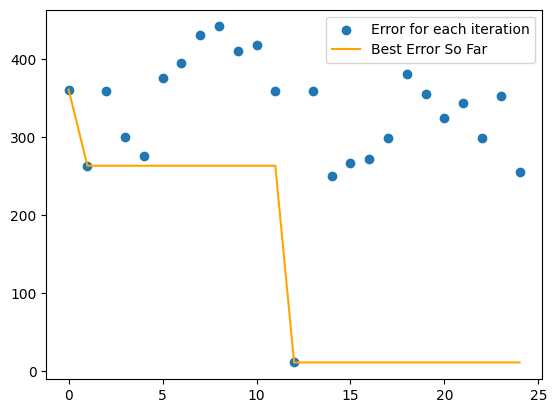

In [114]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 999999
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

## (4) Bayesian Optimisation with Microbit measurements

In [115]:
import serial

In [116]:
!ls /dev/cu.*

/dev/cu.Bluetooth-Incoming-Port /dev/cu.ZeitlersBoseQC35II
/dev/cu.RoastBeats              /dev/cu.usbmodem102


In [117]:
ser = serial.Serial()
ser = serial.Serial("/dev/cu.usbmodem102",115200, timeout=0.1)

In [118]:
import time
def characterise(wait=0.5):
    valid = False
    while not valid:
        try:
            ser.flushInput()
            ser.write(b",")
            serial_data = str(ser.readline().decode('utf8')).rstrip()
            rgb = tuple([int(value) for value in serial_data.split("-")])
            # Validate: Measurement needs three entries
            if len(rgb) != 3:
                print(f"Measurement did not containt 3 RGB values:{rgb}")
                raise Exception()
            # Validate: Measurements need to be between 0 and 255
            if sum([0 <= x <= 255 for x in rgb]) != 3:
                print(f"Measurement outside valid range [0,255]:{rgb}")
                raise Exception()
            valid = True
        except Exception as e:
            print(f"Measurement invalid, will try again (error: {str(e)})")
    print(f"New RGB Measurement: {rgb}")
    time.sleep(wait)
    return rgb

In [119]:
characterise()

New RGB Measurement: (90, 90, 76)


(90, 90, 76)

In [120]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [121]:
import pandas as pd
def calculate_candidate(samples):
    train_X = samples[["R","G","B"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(-1*train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    from botorch.acquisition import UpperConfidenceBound
    UCB = UpperConfidenceBound(gp, beta=0.1)
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(3), torch.ones(3)*255])
    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    candidate = {"R": candidate[0], "G": candidate[1], "B": candidate[2]}
    return candidate

In [122]:
import random
import numpy as np
import cv2

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (70,125,50)  # Goal color

# Main loop
max_iterations = 50  # Set the desired number of iterations

# Let us set up a data table to record the data more structured
samples = pd.DataFrame(columns=['R', 'G', 'B', 'error', 'ID'])

candidate_color = (0,0,0) # Initial color

for iteration in range(max_iterations):
    print(f"---Iteration {iteration}")

    # STEP 1: Synthesis
    # Update the live image with the current color
    print(f"Synthesis:{candidate_color}")
    image[:, :] = tuple(reversed(candidate_color))
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    
    # Measure the color with the Microbit: We will do this eventually
    rgb_measurement = characterise(wait=0.2)  
    print(f"Characterisation:{rgb_measurement}")
    #rgb_measurement = (rgb_measurement[0]+np.random.normal(1),rgb_measurement[1]+np.random.normal(1),rgb_measurement[2]+np.random.normal(1))
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    error = calculate_error(goal_color, rgb_measurement)
    print(f"Error:{error}")

    # Add the sample to the data table
    new_sample = pd.DataFrame({"R":rgb_measurement[0], "G":rgb_measurement[1], "B":rgb_measurement[2], "ID":iteration, "error":error}, index=[iteration])
    samples = pd.concat([samples, new_sample], axis=0, ignore_index=True)

    candidate = calculate_candidate(samples)
    candidate_color = (candidate['R'].item(), candidate['G'].item(), candidate['B'].item())
    print(f"Planning: Candidate:{candidate_color}")
    
    # Add text information to the image
    text = f"Iteration: {iteration + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = 50
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), tuple(reversed(goal_color)), -1)

    # Add text for the error
    error_text = f"Error: {error:.2f}"
    cv2.putText(image, error_text, (10, height - 10), font, font_scale, font_color, 2)

    error_values = list(samples['error'].to_numpy())    # Draw the graph of error values
    if len(error_values) > 1:
        for i in range(1, len(error_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(error_values[i - 1] * (height - 60) / max(error_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(error_values[i] * (height - 60) / max(error_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(200)  # Adjust the wait time (in milliseconds) as needed
    
# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

---Iteration 0
Synthesis:(0, 0, 0)
New RGB Measurement: (90, 90, 76)
Characterisation:(90, 90, 76)
Error:47.968739820845826
Planning: Candidate:(24.742786407470703, 126.70474243164062, 147.2547607421875)
---Iteration 1
Synthesis:(24.742786407470703, 126.70474243164062, 147.2547607421875)
New RGB Measurement: (90, 90, 77)
Characterisation:(90, 90, 77)
Error:48.518037882832814
Planning: Candidate:(13.733202934265137, 90.74266815185547, 94.28443145751953)
---Iteration 2
Synthesis:(13.733202934265137, 90.74266815185547, 94.28443145751953)
New RGB Measurement: (58, 109, 100)
Characterisation:(58, 109, 100)
Error:53.85164807134504
Planning: Candidate:(160.808837890625, 89.16996765136719, 90.10165405273438)
---Iteration 3
Synthesis:(160.808837890625, 89.16996765136719, 90.10165405273438)
New RGB Measurement: (58, 109, 100)
Characterisation:(58, 109, 100)
Error:53.85164807134504
Planning: Candidate:(123.91304016113281, 65.6556167602539, 44.254024505615234)
---Iteration 4
Synthesis:(123.9130401

Planning: Candidate:(65.11865234375, 126.2483901977539, 51.41216278076172)
---Iteration 33
Synthesis:(65.11865234375, 126.2483901977539, 51.41216278076172)
New RGB Measurement: (77, 116, 65)
Characterisation:(77, 116, 65)
Error:18.841443681416774
Planning: Candidate:(65.3161849975586, 126.62167358398438, 51.71189880371094)
---Iteration 34
Synthesis:(65.3161849975586, 126.62167358398438, 51.71189880371094)
New RGB Measurement: (77, 117, 65)
Characterisation:(77, 117, 65)
Error:18.384776310850235
Planning: Candidate:(64.8353042602539, 126.60868835449219, 51.39311599731445)
---Iteration 35
Synthesis:(64.8353042602539, 126.60868835449219, 51.39311599731445)
New RGB Measurement: (77, 117, 65)
Characterisation:(77, 117, 65)
Error:18.384776310850235
Planning: Candidate:(64.81053161621094, 126.65504455566406, 51.30257797241211)
---Iteration 36
Synthesis:(64.81053161621094, 126.65504455566406, 51.30257797241211)
New RGB Measurement: (77, 117, 65)
Characterisation:(77, 117, 65)
Error:18.38477631

-1

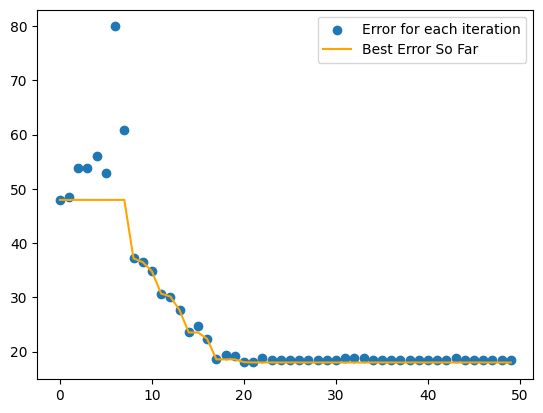

In [123]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.legend()

Let's also plot the RGB colors with it.

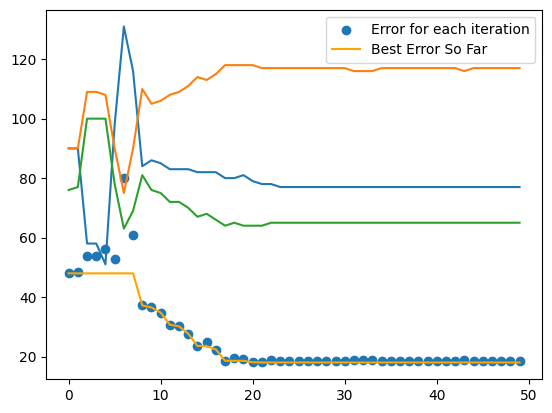

In [124]:
import matplotlib.pyplot as plt
# Plot error for each iteration
plt.scatter(range(len(error_values)), error_values, label="Error for each iteration")

# Calculate best error so far
best_error_so_far = 1000
best_errors = []
for value in error_values:
    if value < best_error_so_far:
        best_error_so_far = value
    best_errors.append(best_error_so_far)
    
# Plot best error so far
plt.plot(best_errors, label="Best Error So Far", color="orange")
plt.plot(samples['R'])
plt.plot(samples['G'])
plt.plot(samples['B'])
plt.legend()